# Use the IRM with weights

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from doubleml._utils_resampling import DoubleMLResampling

In [2]:
def group_effect(x):
    if x[0] <= -0.3:
        te = 2.5
    elif (x[0] >= 0.2) & (x[1] >= 0.4):
        te = 1.5
    else:
        te = -2
    return te

In [3]:
def create_synthetic_group_data(n_samples=200, n_w=10, support_size=5):
    """
    Creates a simple synthetic example for group effects.

    Parameters
    ----------
    n_samples : int
        Number of samples.
        Default is ``200``.

    n_w : int
        Dimension of covariates.
        Default is ``10``.

    support_size : int
        Number of relevant covariates.
        Default is ``5``.

    Returns
    -------
     data : pd.DataFrame
            A data frame.

    """
    # Outcome support
    support_w = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_w = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)
    # Treatment support
    # Assuming the matrices gamma and beta have the same number of non-zero components
    support_t = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_t = np.random.uniform(0, 1, size=support_size)
    # Define the function to generate the noise
    eta_sample = lambda n: np.random.uniform(-1, 1, size=n_samples)

    # Generate controls, covariates, treatments and outcomes
    w = np.random.normal(0, 1, size=(n_samples, n_w))
    # Group treatment effect
    te = np.apply_along_axis(group_effect, axis=1, arr=w)
    # Define treatment
    log_odds = np.dot(w[:, support_t], coefs_t) + eta_sample(n_samples)
    t_sigmoid = 1 / (1 + np.exp(-log_odds))
    t = np.array([np.random.binomial(1, p) for p in t_sigmoid])
    # Define the outcome
    y = te * t + np.dot(w[:, support_w], coefs_w) + epsilon_sample(n_samples)

    # Now we build the dataset
    y_df = pd.DataFrame({'y': y})
    t_df = pd.DataFrame({'t': t})
    w_df = pd.DataFrame(data=w, index=np.arange(w.shape[0]),
                        columns=[f'w_{i}' for i in range(1, w.shape[1] + 1)])

    data = pd.concat([y_df, t_df, w_df], axis=1)
    covariates = list(w_df.columns.values)

    return data, covariates

#### Set up simulation study

In [4]:
# No of repetitions
n_rep = 100
datasets = []

# DGP constants
np.random.seed(42)
n_obs = 5000
n_w = 10
support_size = 5

# For first stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
randomForest_reg = RandomForestRegressor(n_estimators=200, random_state=42)
randomForest_class = RandomForestClassifier(n_estimators=200, random_state=42)

from sklearn.linear_model import LinearRegression, LogisticRegression
lm = LinearRegression()
lr = LogisticRegression(random_state=42)

# Create data
for i in range(n_rep):
    data, covariates = create_synthetic_group_data(n_samples=n_obs, n_w=n_w, support_size=support_size)
    data_dml_base = dml.DoubleMLData(data,
                                     y_col='y',
                                     d_cols='t',
                                     x_cols=covariates)
    datasets.append(data_dml_base)
    

#### Run simulation study

In [29]:
wates = []
gates = []
attes = []
for i in range(100):
    if i%10==0:
        print(i)
    dml_data = datasets[i]
    smpls = DoubleMLResampling(n_folds=5, n_rep=1, n_obs=n_obs,
                               apply_cross_fitting=True, stratify=dml_data.d).split_samples()
    dml_irm = dml.DoubleMLIRM(dml_data,
                              ml_g=randomForest_reg,
                              ml_m=randomForest_class,
                              trimming_threshold=0.01,
                              n_folds=5,
                              draw_sample_splitting=False)
    dml_irm.set_sample_splitting(smpls)
    dml_irm.fit()

    # create groups for WATE and GATE
    groups_1, groups_2 = np.zeros_like(dml_data.y),np.zeros_like(dml_data.y)
    groups_1[np.where(dml_data.x[:,0]<=-0.3)] = 1
    groups_2[np.where((dml_data.x[:,0]>=0.2) & (dml_data.x[:,1]>=0.4))] = 1
    groups_3 = groups_1 + groups_2

    # estimate GATEs
    gate_1 = dml_irm.gate(groups=pd.DataFrame(groups_1)).confint()["effect"][0]
    gate_2 = dml_irm.gate(groups=pd.DataFrame(groups_2)).confint()["effect"][0]
    gate_3 = dml_irm.gate(groups=pd.DataFrame(groups_3)).confint()["effect"][0]
    gates.append([gate_1, gate_2, gate_3])

    # estimate WATEs
    _wates = []
    for groups in [groups_1,groups_2,groups_3]:
        dml_irm_wate = dml.DoubleMLIRM(dml_data,
                                   ml_g=randomForest_reg,
                                   ml_m=randomForest_class,
                                   trimming_threshold=0.01,
                                   n_folds=5,
                                   draw_sample_splitting=False,
                                   weights=groups)
        dml_irm_wate.set_sample_splitting(smpls)
        dml_irm_wate.fit()
        _wates.append(dml_irm_wate.coef[0])
        wates.append(_wates)

0
10
20
30
40
50
60
70
80
90


In [40]:
dml_irm_wate = dml.DoubleMLIRM(dml_data,
                            ml_g=randomForest_reg,
                            ml_m=randomForest_class,
                            trimming_threshold=0.01,
                            n_folds=5,
                            draw_sample_splitting=False,
                            weights=np.abs(groups_3-1))
dml_irm_wate.set_sample_splitting(smpls)
dml_irm_wate.fit()

In [30]:
import seaborn as sns
gates_df = pd.DataFrame(gates)
wates_df = pd.DataFrame(wates)

<AxesSubplot: xlabel='0', ylabel='Density'>

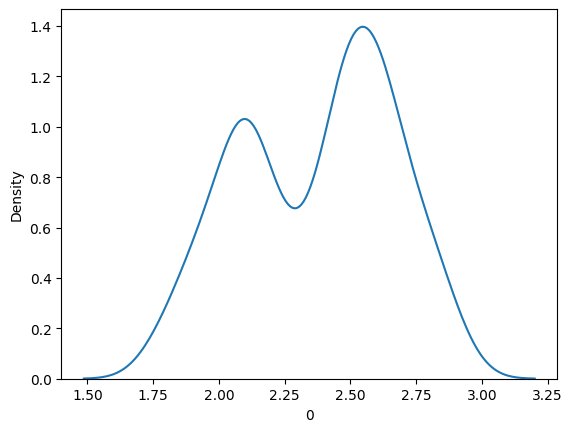

In [38]:
sns.kdeplot(wates_df[0])

#### Baseline IRM Model without Weights

In [5]:
dml_irm_0 = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5)
print("Training IRM Model")
print(dml_irm_0.fit(store_predictions=True))

Training IRM Model
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['t']
Covariates: ['w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'w_7', 'w_8', 'w_9', 'w_10']
Instrument variable(s): None
No. Observations: 500

------------------ Score & algorithm ------------------
Score function: ATE
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(n_estimators=200, random_state=42)
Learner ml_m: RandomForestClassifier(n_estimators=200, random_state=42)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[0.73537189]]
Learner ml_g1 RMSE: [[1.0429027]]
Learner ml_m RMSE: [[0.46644759]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1
Apply cross-fitting: True

------------------ Fit summary       ------------------
      coef   std err         t     P>|t|     2.5 %    97.5 %
t  0.41154  

We create weights according to the DGP

In [23]:
groups_1, groups_2 = np.zeros_like(data.y.values),np.zeros_like(data.y.values)
groups_1[np.where(data["w_1"].values<=-0.3)] = 1
groups_2[np.where((data["w_1"].values>=0.2) & (data["w_2"].values>=0.4))] = 1
groups_3 = groups_1 + groups_2
weights_1 = groups_1 / groups_1.mean()
weights_2 = groups_2 / groups_2.mean()
weights_3 = groups_3 / groups_3.mean()

Compare weighted ATE to GATE estimation

In [16]:
dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5,
                          weights=weights_1)
print("Training IRM Model")
dml_irm.fit(store_predictions=True)
print(dml_irm.summary)
print(dml_irm_0.gate(groups=pd.DataFrame(groups_1)).confint())

Training IRM Model
       coef   std err          t         P>|t|     2.5 %   97.5 %
t  2.613093  0.216344  12.078407  1.373543e-33  2.189066  3.03712
      2.5 %    effect    97.5 %
0  2.374641  2.642063  2.909486


In [20]:
dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5,
                          weights=weights_2)
print("Training IRM Model")
dml_irm.fit(store_predictions=True)
print(dml_irm.summary)
print(dml_irm_0.gate(groups=pd.DataFrame(groups_2)).confint())

Training IRM Model
       coef   std err         t         P>|t|     2.5 %    97.5 %
t  1.732115  0.241235  7.180202  6.960840e-13  1.259303  2.204926
     2.5 %    effect    97.5 %
0  1.35915  1.765627  2.172105


In [34]:
dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=randomForest_reg,
                          ml_m=randomForest_class,
                          trimming_threshold=0.01,
                          n_folds=5,
                          weights=weights_3)
print("Training IRM Model")
dml_irm.fit(store_predictions=True)
print(dml_irm.summary)
print(dml_irm_0.gate(groups=pd.DataFrame(groups_3)).confint())

Training IRM Model
       coef   std err          t         P>|t|     2.5 %    97.5 %
t  2.219536  0.146039  15.198293  3.629578e-52  1.933306  2.505766
      2.5 %    effect    97.5 %
0  2.104724  2.334826  2.564927


Compare weighted ATE to ATTE estimation

In [38]:
res_1, res_2 = np.hsplit(np.c_[weights,weights_bar], 2)
res_1.shape

(500, 1)

In [26]:
dml_irm.predictions["ml_m"][:,0,0].shape

(500,)

In [11]:
smpls = DoubleMLResampling(n_folds=5, n_rep=1, n_obs=n_obs,
                               apply_cross_fitting=True, stratify=data_dml_base.d).split_samples()

dml_irm_atte = dml.DoubleMLIRM(data_dml_base,
                          ml_g=lm,
                          ml_m=lr,
                          trimming_threshold=0.01,
                          n_folds=5,
                          score="ATTE",
                          draw_sample_splitting=False)
dml_irm_atte.set_sample_splitting(smpls)
print("Training IRM Model")
np.random.seed(42)
dml_irm_atte.fit(store_predictions=True)
print(dml_irm_atte.summary)
m_hat = dml_irm_atte.predictions["ml_m"][:,0,0]
weights = data.t.values / data.t.values.mean()
weights_bar = m_hat / data.t.values.mean()
dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=lm,
                          ml_m=lr,
                          trimming_threshold=0.01,
                          n_folds=5,
                          weights=np.c_[weights,weights_bar],
                          draw_sample_splitting=False)
dml_irm.set_sample_splitting(smpls)
print("Training IRM Model")
np.random.seed(42)
dml_irm.fit(store_predictions=True)
print(dml_irm.summary)

Training IRM Model
       coef   std err         t         P>|t|     2.5 %    97.5 %
t  0.342102  0.046336  7.383037  1.547192e-13  0.251285  0.432919
Training IRM Model
       coef   std err         t         P>|t|     2.5 %    97.5 %
t  0.342102  0.046576  7.345073  2.056461e-13  0.250815  0.433389
